In [1]:
import dataset
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
#download spacy english and restart kernel when loading the first time
#!python -m spacy download en_core_web_lg

In [3]:
data_location = "../dataset"

In [4]:
#define the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [5]:
#testing the dataset class
flickr_dataset =  dataset.FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)


Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


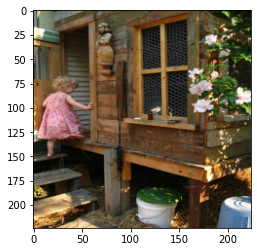

In [6]:
img, caps = flickr_dataset[0]
plt.imshow(img.numpy().transpose((1, 2, 0)))
print("Token:",caps)
print("Sentence:")
print([flickr_dataset.vocab.itos[token] for token in caps.tolist()])

### Training

In [7]:
from lstm_base import BaseLSTM

In [93]:
#from lstm_base import BaseLSTM

import torch
import torch.nn as nn
from torchvision import models
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence

class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        resnet = models.resnet152(pretrained = True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # resnet without the classification fc layer and batchnorm layer
        self.convs =  nn.Sequential(*list(resnet.children())[:-1])
        
        # resnet to embedding size
        self.linear = nn.Linear(resnet.fc.in_features, embedding_size)


    def forward(self, images):
        conv_out = self.convs(images)
        
        # reduce to 1d
        features = Variable(conv_out.data)
        features = features.view(features.size(0), -1)
        #print('Conv out shape')
        #print(features.size())
        out = self.linear(features)
        return out
    


        
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
        return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
        torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
        captions = captions[:,:-1]      
        self.batch_size = features.shape[0]
        self.hidden = self.init_hidden( self.batch_size )
        embeds = self.word_embedding( captions )
        inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
        lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
        outputs = self.fc( lstm_out )      
        return outputs

    def Predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if len(final_ouput) >=20 :
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output
        
class BaseLSTM(nn.Module):      
    def __init__(self, embedding_size, hidden_size, vocab, n_layers = 2):
        super(BaseLSTM, self).__init__()
        self.encoder = Encoder(embedding_size)
        self.decoder = DecoderRNN(embedding_size, hidden_size, len(vocab), n_layers)
    
    
    def forward(self, images, captions = None): #, lengths = None):
        encodings = self.encoder(images)
        return self.decoder(encodings, captions)#, lengths)

In [94]:
model = BaseLSTM(300, 200, flickr_dataset.vocab)

In [95]:
lengths = (torch.Tensor([0.6, 0.2, 0.2])*len(flickr_dataset)).int()

In [96]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset = flickr_dataset, lengths = lengths)

In [97]:
BATCH_SIZE = 1
NUM_WORKER = 1

#token to represent the padding
pad_idx = flickr_dataset.vocab.stoi["<PAD>"]




train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=dataset.CapsCollate(pad_idx=pad_idx,batch_first=True)
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=dataset.CapsCollate(pad_idx=pad_idx,batch_first=True)
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=dataset.CapsCollate(pad_idx=pad_idx,batch_first=True)
)


In [98]:
_ = model.train()

In [ ]:
LEARNING_RATE = 1e-5
EPOCHS = 10

if __name__ == "__main__": 
    device = torch.device("cuda")
    print(torch.cuda.memory_allocated(device))
    # to cuda device
    model = model.to(device)
    print(torch.cuda.memory_allocated(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for i in range(EPOCHS):
        for idx, (imgs, caps) in enumerate(tqdm(train_loader)):
            #if len(imgs) > 1:
            optimizer.zero_grad()
            model.encoder.zero_grad()
            model.decoder.zero_grad()
            imgs, caps = imgs.to(device), caps.to(device)

            #targets = pack_padded_sequence(caps, lens, batch_first=True, enforce_sorted=False)[0]


            out = model(imgs, caps)
            loss = criterion(out.view(-1, len(flickr_dataset.vocab)) , caps.view(-1))
            loss.backward()
            optimizer.step()


            if (idx+1)%50 == 0:
                print("loss: {:.5f}".format(loss.item()))

        # evaluate on validation set
        

        #model.eval()
        #with torch.no_grad():
        #    for imgs, caps in tqdm(val_loader):
        #            imgs, caps = imgs.to(device), caps.to(device)

        #            out = model(imgs)

        #            preds += torch.max(out, 1)[1].cpu().tolist()
        #            targets += torch.max(labels, 1)[1].cpu().tolist()
        
            
        #model.train()

278055936
524964864


  0%|          | 54/24273 [00:02<18:16, 22.09it/s] 

loss: 7.98631


  0%|          | 102/24273 [00:04<19:15, 20.91it/s]

loss: 7.98036


  1%|          | 153/24273 [00:07<18:00, 22.33it/s]

loss: 7.96764


  1%|          | 204/24273 [00:09<18:10, 22.07it/s]

loss: 7.89808


  1%|          | 252/24273 [00:11<18:53, 21.19it/s]

loss: 7.94420


  1%|          | 303/24273 [00:13<17:14, 23.16it/s]

loss: 7.92838


  1%|▏         | 354/24273 [00:15<16:08, 24.69it/s]

loss: 7.79671


  2%|▏         | 402/24273 [00:17<18:15, 21.80it/s]

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# See this for input references - https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu
# A Caption should be a list of strings.
# Reference Captions are list of actual captions - list(list(str))
# Predicted Caption is the string caption based on your model's output - list(str)
# Make sure to process your captions before evaluating bleu scores -
# Converting to lower case, Removing tokens like <start>, <end>, padding etc.

def bleu1(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)


def bleu4(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)

Token: tensor([   1,   50,  321, 1904,   11,   30,   16,   21,   51,   98,   13,   10,
          52,    5,    2])
Sentence:
['<SOS>', 'two', 'different', 'breeds', 'of', 'brown', 'and', 'white', 'dogs', 'play', 'on', 'the', 'beach', '.', '<EOS>']


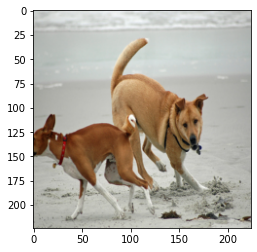

In [84]:
img, caps = flickr_dataset[100]
plt.imshow(img.numpy().transpose((1, 2, 0)))
print("Token:",caps)
print("Sentence:")
print([flickr_dataset.vocab.itos[token] for token in caps.tolist()])

In [85]:
_ = model.eval()

In [86]:
encoder_out = model.encoder(img[None, :].to(device)).unsqueeze(1)

In [87]:
def Predict(self, inputs, max_len=20):        
    final_output = []
    batch_size = inputs.shape[0]         
    hidden = self.init_hidden(batch_size) 

    while True:
        lstm_out, hidden = self.lstm(inputs, hidden) 
        outputs = self.fc(lstm_out)  
        outputs = outputs.squeeze(1) 
        _, max_idx = torch.max(outputs, dim=1) 
        final_output.append(max_idx.cpu().numpy()[0].item())             
        if (len(final_output) >=20):
            break

        inputs = self.word_embedding(max_idx) 
        inputs = inputs.unsqueeze(1)             
    return final_output

In [88]:
output = Predict(model.decoder, encoder_out)

In [89]:
output

[1, 4, 4, 4, 4, 4, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [90]:

#ref_text = [flickr_dataset.vocab.itos[token] for token in caps.numpy()]
pred_text = [flickr_dataset.vocab.itos[token] for token in output]#.numpy()]

In [91]:
output

[1, 4, 4, 4, 4, 4, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [92]:
pred_text

['<SOS>',
 'a',
 'a',
 'a',
 'a',
 'a',
 '.',
 '<EOS>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']